# Fast-food Analysis

As we have studied if the nutritional informations of the average product per area were correlated to the well-being features, we now want to study the correlation between the nutrients composition and the number of fast-foods per area.

We were able to find the database from the Londonian data website, the same one as for the well-being features. 

In [1]:
# Imports
from utils import calculate_nutripoints
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

## I) Data Preparation 

### A) Data imports

In [2]:
# Data Imports

fast_food = pd.read_excel(
    "data/fast_food_ward.xlsx", sheet_name="Ward Data", header=[3], usecols="E,G")
display(fast_food.head())
print(fast_food.shape)

wellbeing_grocery = pd.read_pickle("data/wellbeing_grocery.pkl")
display(wellbeing_grocery.head())
print(wellbeing_grocery.shape)

grocery_analysis = pd.read_pickle("data/grocery_nutripoints.pkl")
display(grocery_analysis.head())
print(grocery_analysis.shape)

,2015 Ward code,Count of outlets
0,E05001767,10
1,E05001768,10
2,E05001769,22
3,E05001770,81
4,E05001771,5


(5832, 2)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013,nutri_label
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106,4
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499,0
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507,1
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193,0
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500,0


(414, 26)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
488,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0
542,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0
476,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0
486,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0
463,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0


(510, 12)


### B) Merging

We compare the number of lines of grocery dataset and fast-food one and try to see how many they have in common. We then merge the two datasets. We also check that there is no null or NA values.

In [3]:
# check if area id is a unique id
is_area_unique = grocery_analysis["area_id"].is_unique
print(is_area_unique)

True


In [4]:
nr_wards_grocery = len(set(grocery_analysis["area_id"].values))
print(nr_wards_grocery)

510


In [5]:
grocery_analysis.isna().any()

area_id                 False
energy_fat              False
energy_saturate         False
energy_sugar            False
energy_protein          False
energy_carb             False
energy_fibre            False
energy_alcohol          False
energy_tot              False
h_nutrients_calories    False
nutripoints             False
nutri_class             False
dtype: bool

In [6]:
nr_wards_fast_food = len(set(fast_food["2015 Ward code"].values))
print(nr_wards_fast_food)

5832


In [7]:
fast_food.isna().any()

2015 Ward code      False
Count of outlets    False
dtype: bool

In [8]:
fast_food.isnull().any()

2015 Ward code      False
Count of outlets    False
dtype: bool

In [9]:
# calculate number of rows both datasets have in common

nr_wards = len(set(fast_food["2015 Ward code"].values)
    & set(grocery_analysis["area_id"].values))

print(nr_wards)

440


We loose 70 values by merging.  

In [10]:
fastfood_grocery = pd.merge(
    left=grocery_analysis, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_grocery = fastfood_grocery.drop("2015 Ward code", axis=1)
display(fastfood_grocery.head())
print(fastfood_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
0,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0,33
1,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0,7
2,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0,9
3,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0,6
4,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0,1


(440, 13)


We also merge well-being and fast-food in order to check the correlation between the well-being features and the number of fast-food, as we can make some assumptions about how they are linked and maybe prove the reliability of our data. 

In [11]:
fastfood_wellbeing = pd.merge(
    left=wellbeing_grocery, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_wellbeing = fastfood_wellbeing.drop("2015 Ward code", axis=1)
display(fastfood_wellbeing.head())
print(fastfood_wellbeing.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013,nutri_label,Count of outlets
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106,4,15
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499,0,13
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507,1,8
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193,0,14
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500,0,25


(407, 27)


We lose 33 values between well-being and grocery because wellbeing_grocery had already been merged before with year_grocery, leaving aside the area for which we did not have the well-being values.

## II) Comprehension of the data

### A) Distribution of the values: describe, boxplot, distplot

In [12]:
# Understanding better how the values are distributed
fastfood_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,80.653871,31.811113,40.031539,21.093016,71.787149,3.027993,1.679636,178.241665,1.573155,7.575000,1.931818,14.397727
std,2.909051,1.388606,3.306468,0.855441,5.520788,0.117759,0.364883,7.281531,0.025258,2.703463,1.121294,13.933081
min,67.111854,26.173163,30.149908,17.596480,52.921834,2.750710,0.715793,147.541243,1.465237,-1.500000,0.000000,1.000000
25%,78.989452,30.955484,37.927397,20.696160,68.159543,2.947692,1.433929,173.856481,1.556885,6.000000,1.000000,7.000000
50%,80.448641,31.660923,39.643719,21.229909,71.872886,3.022663,1.660522,178.583441,1.573913,7.500000,2.000000,11.000000
75%,82.164445,32.544245,42.018439,21.675982,75.687417,3.093645,1.873801,182.536718,1.590158,9.500000,3.000000,18.000000
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.490972,197.674474,1.680088,15.000000,4.000000,147.000000


<AxesSubplot:ylabel='Count of outlets'>

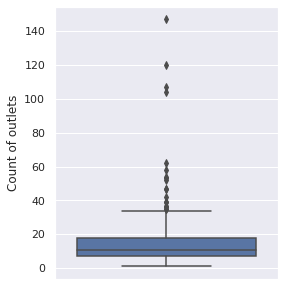

In [13]:
fig = plt.figure(figsize=(4, 5))

sns.boxplot(y=fastfood_grocery["Count of outlets"])

They are many outliers for the number of outlets going up to 147 whereas the median is at 11. Due to this phenomenom, the mean is quite high whereas 75% of the values are between 1 and 18. 

In [14]:
# List of columns of interest in the nutritional dataset
COLUMNS_GROCERY = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories',
    'nutripoints',
    'Count of outlets'
]


# Selection of the numerical columns of interest in the fastfood_grocery dataset
fastfood_grocery_analysis = fastfood_grocery[COLUMNS_GROCERY].copy()

Text(0.5, 0.98, 'histplot for each column')

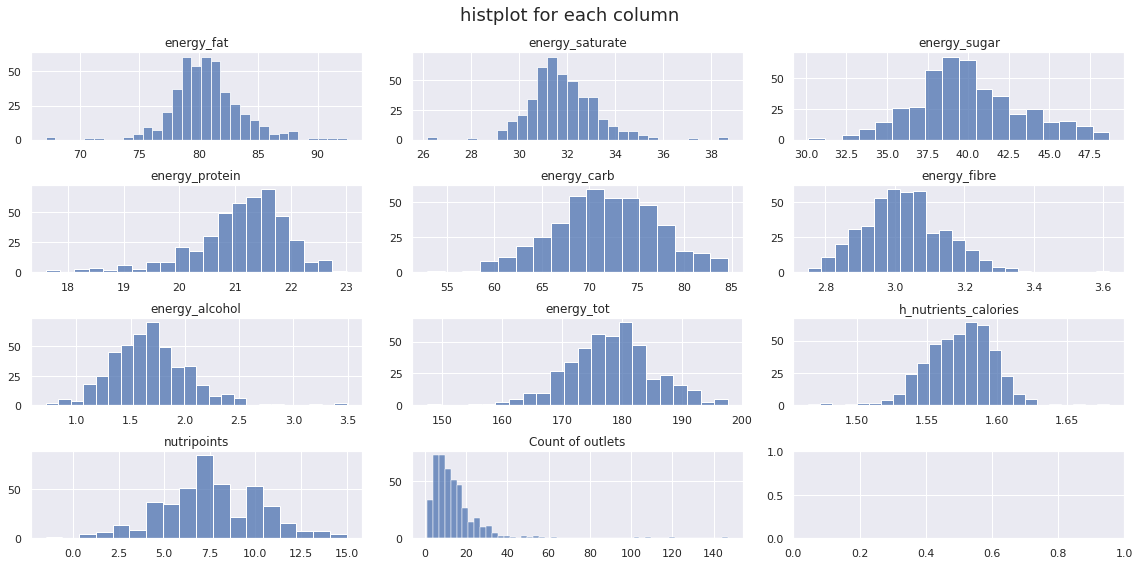

In [15]:
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS_GROCERY)):
    sbplt = ax[int(i/3), i % 3]

    sns.histplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

Most of the nutritional variables seem to be normally distributed. On the other side, the number of outlets is more logarithmic. Most of the areas have between 5 and 10 fast foods but it goes up to 140! 

### B) Correlation between the number of fast food and the different nutritional variables

<AxesSubplot:>

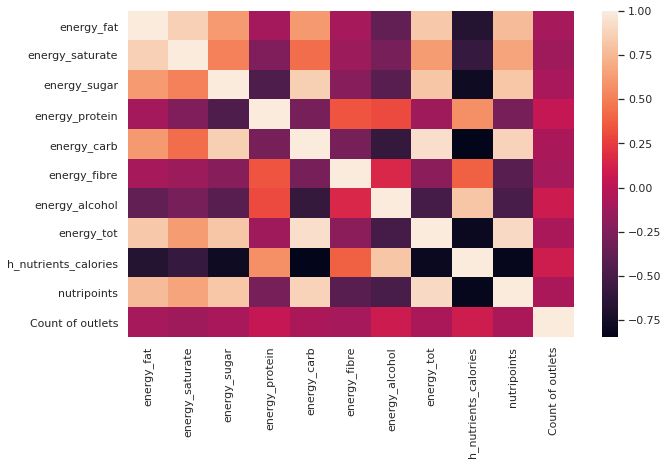

In [16]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_grocery_analysis.corr())

The correlation with the number of oulets (the last column or row) seems really low as the colours are mainly red, corresponding to values around 0. We will display the correlation table for the count of outlets to better understand the importance of the correlation with the nutritional variables. 

In [17]:
correlation = fastfood_grocery_analysis.corr(method="spearman")
display(correlation[["Count of outlets"]])

,Count of outlets
energy_fat,-0.010292
energy_saturate,-0.105991
energy_sugar,-0.012535
energy_protein,0.052572
energy_carb,0.034797
energy_fibre,-0.213410
energy_alcohol,0.000670
energy_tot,0.028182
h_nutrients_calories,-0.018201
nutripoints,0.035695


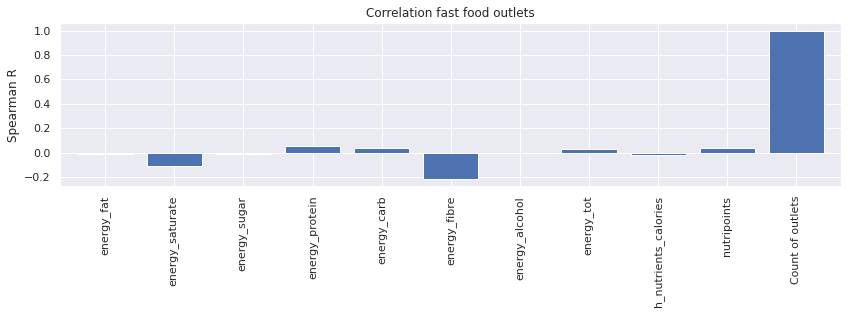

In [18]:
plt.figure(figsize=(14, 3))
correlation["Count of outlets"].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets")
plt.show()

**The number of fast food is not at all correlated with the Nutripoints.** Furthermore, there is almost no correlation with other variables. Therefore, it is hardly justifiable to predict the nutritional informations of the average product of an area from the number of fast-food.

We will however try to further investigate this correlation. 

### C) Correlation between the number of fast food and the well-being measures

In [19]:
# List of columns of interest in the wellbeing dataset
COLUMNS_SCORES = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average Capped GCSE and Equivalent Point Score Per Pupil',
    'Unauthorised Absence in All Schools (%)',
    'Dependent children in out-of-work families',
    'Public Transport Accessibility',
    'Homes with access to open space & nature, and % greenspace',
    'Subjective well-being average score',
    'Index Score 2013',
    'nutripoints',
    'Count of outlets'
]

# Selection of the numerical columns of interest in the wellbeing_grocery dataset
fastfood_wellbeing_analysis = fastfood_wellbeing[COLUMNS_SCORES].copy()

In [20]:
correlation = fastfood_wellbeing_analysis.corr(method="spearman")
display(correlation[["Count of outlets"]])

,Count of outlets
Life Expectancy,-0.258841
Childhood Obesity,-0.228199
Incapacity Benefit rate,-0.169289
Unemployment rate,-0.329209
Crime rate - Index,-0.397001
Deliberate Fires,-0.137302
Average Capped GCSE and Equivalent Point Score Per Pupil,-0.278795
Unauthorised Absence in All Schools (%),-0.211107
Dependent children in out-of-work families,-0.280465
Public Transport Accessibility,0.440609


For the plot, we only keep the variables that have a spearman score higher than 0.2.

In [21]:
fastfood_wellbeing_analysis.drop(columns=['Incapacity Benefit rate',
                                          'Deliberate Fires',
                                          'Average Capped GCSE and Equivalent Point Score Per Pupil',
                                          'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families',
                                          'Homes with access to open space & nature, and % greenspace',
                                          'Subjective well-being average score'], inplace=True)
fastfood_wellbeing_analysis.to_pickle("plot_data/fastfood_wellbeing.pkl")

<AxesSubplot:>

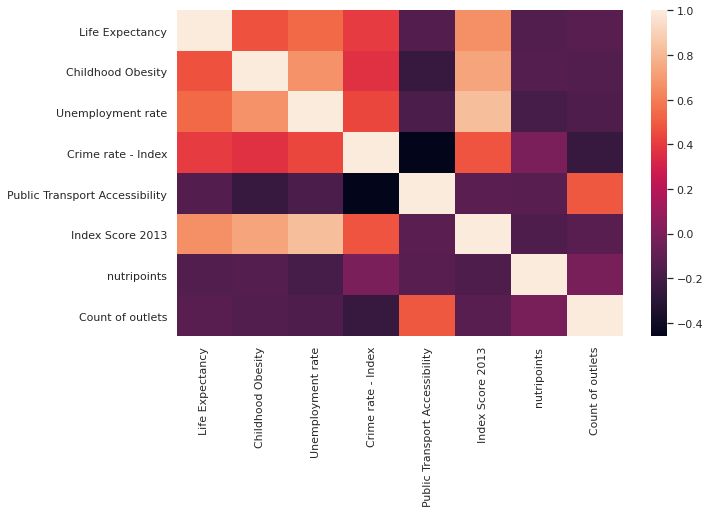

In [22]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_wellbeing_analysis.corr())

In [23]:
correlation_shorten = fastfood_wellbeing_analysis.corr(method="spearman")

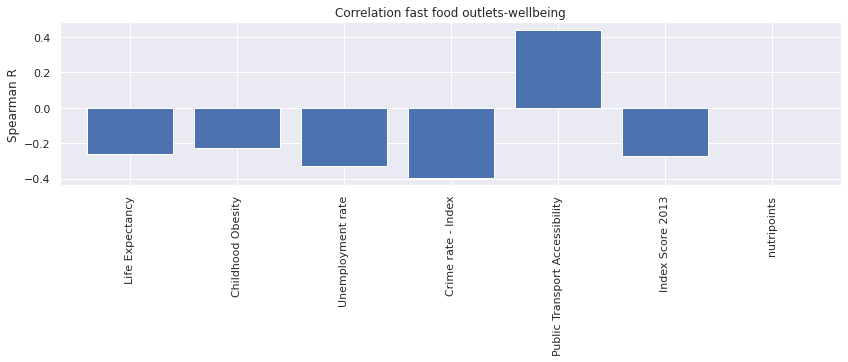

In [24]:
plt.figure(figsize=(14, 3))
correlation_shorten.iloc[0:7, 7].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets-wellbeing")
plt.show()

When talking about fast-food and its relation with well-being variables, it is true that we already have some assumptions in our head. Of course, it is well correlated with Public Transport as to facilitate the access to the public and increase customer rate. On the other hand, Crime rate should be low (as we can see here it is negatively correlated to the number of fast-food) as the clients should feel safe when coming to the restaurants. However, we would have expected that it would be positively correlated with Childhood Obesity and Unemployment rate. We think that as fast-food are cheap, the chains won't target the fancy social class but mostly the ones that need comfort foods. Furthermore, fast-food don't serve healthy food but mostly fat and sugar riched one, causing obesity, so we thought that it was positively correlated with this variable. 

Therefore, some results seem predictable but others aren't. Thus, it is difficult to make a decisive conclusion about the link between fast-food and the Nutripoints of the average product of an area. We then do a regression analysis to see if it justifiable to try to predict Nutripoints from the number of fast-food in an area.

## Regression Analysis

### A) Linear Regression of Nutripoints from the number of fastfood

In [25]:
# Understanding the linear regression between the two variables
Y = fastfood_grocery[["nutripoints"]]
X1 = fastfood_grocery[["Count of outlets"]]
X = sm.add_constant(X1)  # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.185
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.140
Time:                        18:18:20   Log-Likelihood:                -1060.3
No. Observations:                 440   AIC:                             2125.
Df Residuals:                     438   BIC:                             2133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.7718      0.185  

The R-squared is very small: 0.002, meaning we can only predict 0.2% of our Nutripoints from the number of fast food. Furthermore, the coefficient of this latter is neglectable as it is -0.0039, the intercept is the one having the more weight in this regression. Therefore, we can conclude that the Linear Regression is not the adapted regression for prediction of Nutripoints of each area from the number of fast-food. It actually makes sense as there was no correlation between these two variables, it is actually difficult to predict one from the other. 

### B) Gradient boosting Regressor

We know that there is no correlation and that the Linear Regression is not representative at all. However, we still wanted to explore if another type of regression: the Gradient Boosting method, would be more concluent. 

In [26]:
# train a gradient boosting regressor
gradboost = GradientBoostingRegressor()

In [27]:
y = fastfood_grocery["nutripoints"]
predicted_y = cross_val_predict(gradboost, X, y, cv=5)

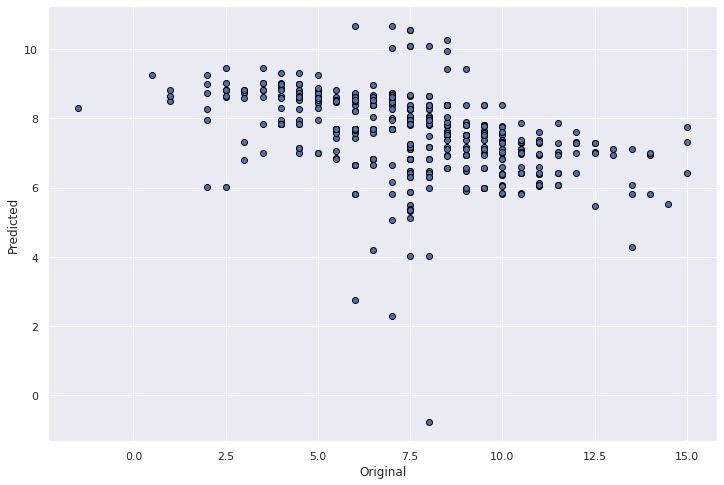

In [28]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(Y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

If the prediction was representative of the nutripoints, we should observe a diagonal line, it is not what we have at all. This means that for a certain Nutripoints value, the predicted one from the Gradient Boosting Regression is higher or smaller than the original value. 

To confirm this assumption, we compute the mean squared error and the R-squared value:

In [29]:
r2 = r2_score(Y, predicted_y)
mse = mean_squared_error(Y, predicted_y)
print(r2, mse)

-0.565986194439277 11.419331487530183


The R-squared is very small and negative. A horizontal line would actually be more representative of our regression. Furthermore, the mean squared error is very high. The regression is therefore not representative neither of our Nutripoints variable. 

## Conclusion 

As the correlation predicted it, it is not possible to find a good regression in order to predict the Nutripoints from the number of fast food of an area. Indeed, there are almost not correlated making it difficult to have high coefficient for our regressions. 

Having the average products per area, actually, makes it difficult to have a representation of how healthy the inhabitants of an area consume. A high Nutripoint doesn't necessary mean that all the consumers of this area consume more fatty or sugary products. Furthermore, an unhealthy average product is not linked to a high number of fast-foods. However, it could be interesting to see if the richest areas have less fast-foods making the assumption that the inhabitants would prefer to go in a real restaurant.  